In [47]:
import tensorflow as tf
import tensorflow.keras.models

import numpy as np
import matplotlib.pyplot as plt

n_pts = 1000
random_state = 1

np.random.seed(random_state)

xyz = np.random.rand(n_pts, 4)

s1 = np.column_stack([xyz[:,0],xyz[:,1],xyz[:,3]])
s2 = np.column_stack([xyz[:,0]+xyz[:,1],xyz[:,2]])

print(s1.shape)
print(s2.shape)

fig,ax=plt.subplots(1,1,figsize=(2,2))
ax.scatter(*xyz[:,:2].T, s=25,c=s2[:,0])

(1000, 3)
(1000, 2)


(1000, 5)
29/29 [==============================] - 0s 6ms/step - loss: 0.1527 - mse: 0.1527 - val_loss: 0.1503 - val_mse: 0.1503
(1000, 303)


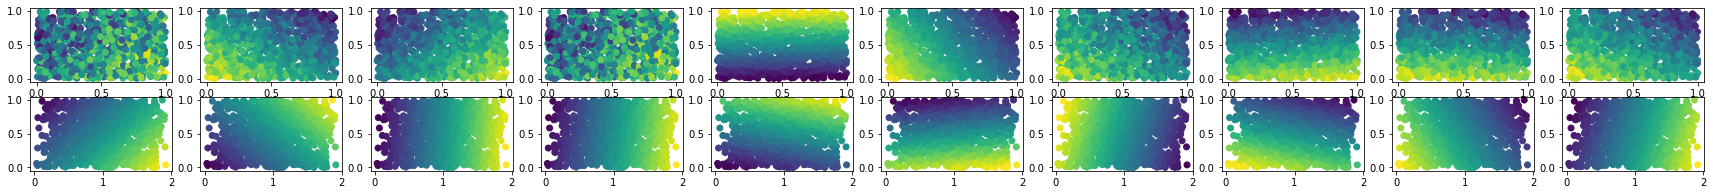

In [71]:
class CommonEigensystemModel(tf.keras.Model):

    @staticmethod
    def define_forward_model(n_input_dimensions, n_output_dimensions, n_layers, n_dim_per_layer, name):
        inputs = tf.keras.layers.Input((n_input_dimensions,), dtype=tf.float32, name=name + '_inputs')
        gp_x = inputs
        for i in range(n_layers):
            gp_x = tf.keras.layers.Dense(n_dim_per_layer, activation="tanh",
                                name=name + "_hidden/dense_{}".format(i))(gp_x)
        gp_output_mean = tf.keras.layers.Dense(n_output_dimensions, name=name + "_output_mean", activation=None)(gp_x)
            
        gp = tf.keras.Model(inputs, gp_output_mean, name=name + "_model")
        return gp, inputs, gp_x
    
    def __init__(self, s1_in, s2_in, d, n_out, batch_size=16, random_state=1):
        super(CommonEigensystemModel, self).__init__()
        self.s1_in = s1_in
        self.s2_in = s2_in
        self.d = d
        
        n_layers = 2
        n_dim_per_layer = d
        self.model1, self.inputs1, self.hidden1 = self.define_forward_model(s1_in, s1_in, n_layers, n_dim_per_layer, 'model1')
        self.model2, self.inputs2, self.hidden2 = self.define_forward_model(s2_in, s2_in, n_layers, n_dim_per_layer, 'model2')
        
    def call(self, inputs, training=False):
        input1, intput2 = tf.split(inputs, num_or_size_splits=[self.s1_in, self.s2_in])
        return self.model1(input1), self.model2(input2)
    
    def inner_layers(self, inputs):
        input1, intput2 = tf.split(inputs, num_or_size_splits=[self.s1_in, self.s2_in])
        return self.hidden1(input1), self.hidden2(input2)
        
        
n_functions = 150
learning_rate = 1e-3
d = 50

def train_func(sensor_data):
    return sensor_data+np.sin(15*sensor_data)

sall = np.column_stack([s1,s2])
print(sall.shape)

if False:
    cemodel1 = CommonEigensystemModel(s1.shape[1], s2.shape[1], d, n_functions)
    cemodel1.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse', metrics=['mse'])

    cemodel1.fit(sall, sall, epochs=10, validation_split=0.1, verbose=False)

    cem1_functions, cem2_functions = cemodel1.inner_layers(sall)

else:
    s1_in = s1.shape[1]
    s2_in = s2.shape[1]
    n_out = n_functions
    
    cemodel1 = tf.keras.Sequential([
    tf.keras.layers.Dense(n_out, input_shape=(s1_in,), name='layer_in'),
    tf.keras.layers.Dense(n_out, activation=tf.nn.sigmoid, kernel_initializer='random_normal', bias_initializer='zero'),
    tf.keras.layers.Dense(s1_in, name='layer_out', activation=tf.nn.sigmoid,kernel_initializer='random_normal', bias_initializer='zero')
    ])
    cemodel1.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate), loss='mse', metrics=['mse'])
    cemodel1.fit(s1, train_func(s1), validation_split=0.1)
    
    cemodel2 = tf.keras.Sequential([
    tf.keras.layers.Dense(n_out, input_shape=(s2_in,), name='layer_in', activation=tf.nn.sigmoid, kernel_initializer='random_normal', bias_initializer='zero'),
    tf.keras.layers.Dense(n_out, activation=tf.nn.sigmoid, kernel_initializer='random_normal', bias_initializer='zero'),
    tf.keras.layers.Dense(s2_in, name='layer_out', activation=tf.nn.sigmoid,kernel_initializer='random_normal', bias_initializer='zero')
    ])
    cemodel2.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate), loss='mse', metrics=['mse'])
    cemodel2.fit(s2, train_func(s2), validation_split=0.1)
    
    cem1_functions = []
    for layer in cemodel1.layers:
        intermediate_layer_model = tf.keras.Model(inputs=cemodel1.input, outputs=layer.output)
        new_data = intermediate_layer_model.predict(s1)
        
        if len(cem1_functions)==0:
            cem1_functions = new_data
        else:
            cem1_functions = np.column_stack([cem1_functions, new_data])
        
    cem2_functions = []
    for layer in cemodel2.layers:
        intermediate_layer_model = tf.keras.Model(inputs=cemodel2.input, outputs=layer.output)
        new_data = intermediate_layer_model.predict(s2)
        
        if len(cem2_functions)==0:
            cem2_functions = new_data
        else:
            cem2_functions = np.column_stack([cem2_functions, new_data])
    
        
    
print(cem1_functions.shape)

n_plots = 10
n_plot_pts = 1000
fig,ax=plt.subplots(2,n_plots,figsize=(3*n_plots,3))
for k in range(n_plots):
    ax[0,k].scatter(s1[0:n_plot_pts,1],s1[0:n_plot_pts,0],c=cem1_functions[:n_plot_pts,k])
    ax[1,k].scatter(*s2[0:n_plot_pts,:2].T, c=cem2_functions[:n_plot_pts,k])

In [72]:
n_d = 100
u1,s,v = np.linalg.svd(cem1_functions, full_matrices=False)
u2,s,v = np.linalg.svd(cem2_functions, full_matrices=False)
uc,s,v = np.linalg.svd(np.column_stack([u1[:,0:n_d],u2[:,0:n_d]]) / np.sqrt(2), full_matrices=False)

In [73]:
fig,ax=plt.subplots(2,n_plots,figsize=(n_plots*3,5))
for k in range(n_plots):
    ax[0,k].scatter(*xyz[0:n_plot_pts,:2].T, c=uc[0:n_plot_pts,k])
    ax[1,k].scatter(*xyz[0:n_plot_pts,:2].T, c=uc[0:n_plot_pts,k])
    
fig,ax=plt.subplots(1,1,figsize=(3,3))
ax.plot(s[0:20],'.');